In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

## ConvNet

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3641)

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

Helper function to quickly normalize with the mean and standard deviation from our training set:

In [4]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [6]:
??Dataset


Let's check it behaved properly.

In [7]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [8]:
# check validation set, too
x_valid.mean(),x_valid.std()

(tensor(-0.0058), tensor(0.9924))

In [9]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [10]:
??get_dls

To refactor layers, it's useful to have a `Lambda` layer that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

NB: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with PyTorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [11]:
nn.Module

torch.nn.modules.module.Module

In [12]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

This one takes the flat vector of size `bs x 784` and puts it back as a batch of images of 28 by 28 pixels:

In [13]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

We can now define a simple CNN.

In [14]:
??nn.Conv2d

### Building the model

#### Mini-review of how convolutions work


Consider the model specified by this call to `get_cnn_model()`:

    def get_cnn_model(data):

        return nn.Sequential(
            Lambda(mnist_resize),                               # 28x28     input layer
            nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), # 8x14x14   first convolution layer
            nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 16x7x7    second convolution layer
            nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 32x4x4    third convolution layer
            nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 32x2x2    fourth convolution layer
            nn.AdaptiveAvgPool2d(1),                            # 32x1x1    adaptive average pooling layer
            Lambda(flatten),                                    # 32x1      flatten
            nn.Linear(32,data.c)                                # 10x1      output layer
        )


Let's consider the first convolution layer. The inputs to nnConv2d specify $1$ input channel, $8$ output channels, a $5\times5$ kernel, zero-padding of $2$ pixels, and a stride length of $2$. Now the input image is $28\times28$, and with $2$ pixels of padding on each side the image array becomes $32\times32$.

If we line up a $5\times5$ kernel at an initial position at the top left of this image, then column $5$ of the kernel lines up with column $5$ of the image, and row $5$ of the kernel lines up with row $5$ of the image. Sliding the kernel rightwards across the image in steps (stride) of $2$ pixels until there is no more room to slide yields a total of $(32-5)//2 + 1 = 14$ kernel positions, including the initial one.

By the same reasoning, since the image is square, starting from the initial position and sliding the kernel downwards across the image in steps of $2$ pixels, again yields $14$ kernel positions.

At each of the $14\times14$ kernel positions, the kernel is 'applied' on the overlapping $5\times5$ portion of the image by multiplying each pixel value by its corresponding kernel array value. We sum these $5\times5=25$ products to obtain a single scalar value, which is the pixel value at this position.

How many weights do we need to fit in this layer? The convolution kernel is $5\times5$, and we need a different kernel  for each of the $8$ output channels.  So altogether there are $5\times5\times8 = 200$ weights to determine for the first layer, assuming the bias vector is all zeros.

The output of the first layer is a stack of $8$ channels of $14\times14$ arrays, which is a $8\times14\times14$ array, which has 1568 entries. 

How many parameters are needed for this model? Start with the convolution layers: $5\times5\times8 = 200$ for the first, $3\times3\times16 = 144$ for the second, $3\times3\times32 = 288$ for the third, $3\times3\times32 = 288$ for the fourth. The total for the convolution layers is $200 + 144 + 288 + 288 = 920$ parameters. The final fully connected linear layer maps the vector of $32$ values returned by the AdaptiveAveragePool layer to the vector of $10$ output parameters. This mapping requires a $32\times10$ matrix, which has $320$ parameters. The AdaptiveAvgPool layer and the Lambda(flatten) layer have no parameters to solve. So the model has to determine a total number of  $920 + 320 = 1240$ parameters; for this calculation we have ignored bias parameters.  The number of input data points for each example is $28\times28=784$, and there are over 50,000 training examples, so the number of data points is vastly larger than the number of parameters!

Now test your understanding by working out the sizes of the remaining layers and checking against the answers provided in the comments to get_cnn_model() below!

In [15]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),                               # 28x28     input layer
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), # 8x14x14   first convolution layer
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 16x7x7    second convolution layer
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 32x4x4    third convolution layer
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 32x2x2    fourth convolution layer
        nn.AdaptiveAvgPool2d(1),                            # 32x1x1    adaptive averaage pooling layer
        Lambda(flatten),                                    # 32x1      flatten
        nn.Linear(32,data.c)                                # 10x1      output layer
    )

In [16]:
model = get_cnn_model(data)

In [17]:
model.training

True

Basic callbacks from the previous notebook:

In [18]:
# list of callbacks
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [19]:
# create Optimizer, Learner, and Runner objects
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [20]:
Runner

exp.nb_05b.Runner

### on CPU, 1 epoch in 10 sec 

In [21]:
# train
%time run.fit(1, learn)

train: [1.9668675, tensor(0.3243)]
valid: [0.96056142578125, tensor(0.6831)]
Wall time: 10.6 s


This took a long time to run, so it's time to use a GPU. We want to put the model and the data on the same GPU device.  We make this happen with a simple Callback.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3799)

## Use CUDA to put the model on GPU

### Method #1

In [22]:
# Somewhat more flexible way
device = torch.device('cuda',0)

In [23]:
class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)

### Method #2 (we'll export this one)

In [24]:
# Somewhat less flexible, but quite convenient
torch.cuda.set_device(device)

In [25]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [26]:
# add CudaCallback to callback functions list
cbfs.append(CudaCallback)

In [27]:
print(cbfs)
print(len(cbfs))

[<class 'exp.nb_05b.Recorder'>, functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x000001C7EA48D378>), <class '__main__.CudaCallback'>]
3


In [28]:
# create model
model = get_cnn_model(data)

In [29]:
model.training

True

In [30]:
# create Optimizer, Learner, and Runner objects
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

### With GPU, 3 epochs
Faster than CPU

In [31]:
# train on GPU
#     Q: why does first time takes 7 sec, but (see below) second time takes 3 sec?
%time run.fit(3, learn)

train: [1.84112859375, tensor(0.3919, device='cuda:0')]
valid: [0.68143642578125, tensor(0.7719, device='cuda:0')]
train: [0.3599805078125, tensor(0.8899, device='cuda:0')]
valid: [0.19260345458984374, tensor(0.9432, device='cuda:0')]
train: [0.198495625, tensor(0.9399, device='cuda:0')]
valid: [0.136022509765625, tensor(0.9611, device='cuda:0')]
Wall time: 7.4 s


Now, that's definitely faster!

## Refactor model

First we can regroup all the conv/relu in a single function:

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3961)

In [32]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

Another thing is that we can do the mnist resize in a batch transform, that we can do with a Callback.

In [33]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

### Add BatchTransformCallback() and mnist_view to our list of callback functions.

In [34]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [35]:
# list of callback functions
print(cbfs)
print(len(cbfs))

[<class 'exp.nb_05b.Recorder'>, functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x000001C7EA48D378>), <class '__main__.CudaCallback'>, functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x000001C780032378>)]
4


In [36]:
size=(1,28,28)
# tacks on a prefix of -1
((-1,)+size)

(-1, 1, 28, 28)

With the `AdaptiveAvgPool`, this model can now work on any size input:

In [37]:
# `nfs` is shorthand for a list of the 'number of filters' (or channels) of each convolution layer
# Here is a list of the number of filters for the convolution layers (first four layers) of our model.
#     See get_cnn_model() above
nfs = [8,16,32,32]
nfs

[8, 16, 32, 32]

In [38]:
# The two functions below construct the same MNIST model we defined above in get_cnn_model()
def get_cnn_layers(data, nfs):
    # add [1] to the beginning of the list, to represent the number of filters of the input layer.
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

And this helper function will quickly give us everything needed to run the training.

In [39]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

### Build the model and the Learner and Runner objects

In [40]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [41]:
model.training

True

In [42]:
model.train

<bound method Module.train of Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)>

In [43]:
print(model)
print('Model has ',len(model),' layers')

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)
Model has  7  layers


### Run the model

In [44]:
# train
%time run.fit(3, learn)

train: [1.99789109375, tensor(0.3035, device='cuda:0')]
valid: [0.79052109375, tensor(0.7411, device='cuda:0')]
train: [0.5630117578125, tensor(0.8192, device='cuda:0')]
valid: [0.27856494140625, tensor(0.9161, device='cuda:0')]
train: [0.22609205078125, tensor(0.9310, device='cuda:0')]
valid: [0.15293565673828124, tensor(0.9540, device='cuda:0')]
Wall time: 3.49 s


In [45]:
# after training, the model.training property is left in the False state
model.training

False

## Hooks

### Manual insertion of a 'hook' function into SequentialModel()

Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually like this:

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4353)

In [46]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        print('__init__ just executed...')
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            if(self.training):
                self.act_means[i].append(x.data.mean())
                self.act_stds [i].append(x.data.std ())
        #print('__call__ just executed...')
        return x
    
    def __iter__(self): return iter(self.layers)

 Note: the `__init__` method happens when the class is called to initialize the *instance*, 
        while the `__call__` method happens when the *instance* is called

In [47]:
# create the model
model =  SequentialModel(*get_cnn_layers(data, nfs))

__init__ just executed...


In [48]:
# create the Learner and Runner objects
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [49]:
dir(model)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backend',
 '_backward_hooks',
 '_buffers',
 '_construct',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_tracing_name',
 '_version',
 'act_means',
 'act_stds',
 'add_module',
 'apply',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'float',
 'forward',
 'half

In [50]:
model.training

True

In [51]:
# activation means
model.act_means

[[], [], [], [], [], [], []]

In [52]:
# train
run.fit(2, learn)

train: [2.1644134375, tensor(0.2307, device='cuda:0')]
valid: [1.8114626953125, tensor(0.3429, device='cuda:0')]
train: [0.921784609375, tensor(0.7050, device='cuda:0')]
valid: [0.316564599609375, tensor(0.9064, device='cuda:0')]


### Now we can have a look at the evolution of the means and stds of the activations during  training.

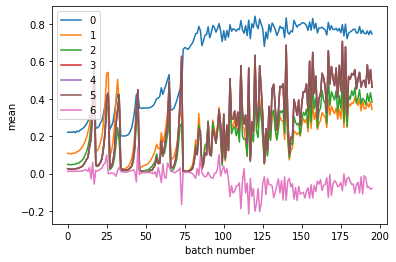

In [53]:
for layer in model.act_means: plt.plot(layer)
plt.legend(range(7))
plt.xlabel('batch number')
plt.ylabel('mean');

In [54]:
# with batch size of 512, the training set is divided into 98 batches, which is one epoch
512*98

50176

In [55]:
# In two epochs, there are 2x98 = 196 batches
print(len(model.act_means[0]))

196


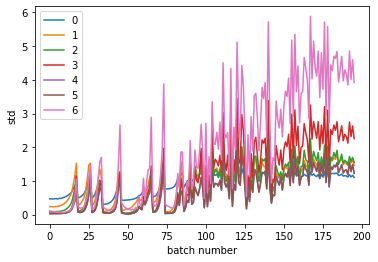

In [56]:
for layer in model.act_stds: plt.plot(layer)
plt.legend(range(7))
plt.xlabel('batch number')
plt.ylabel('std');

### Zoom in to the start of training

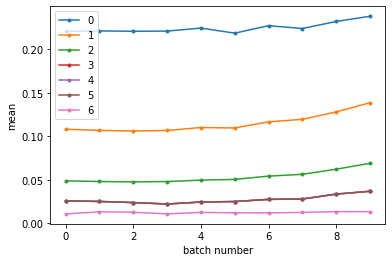

In [57]:
for layer in model.act_means: plt.plot(layer[:10],marker = '.')
plt.legend(range(7))
plt.xlabel('batch number')
plt.ylabel('mean');

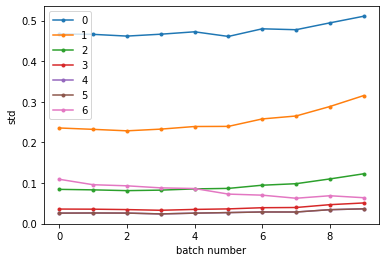

In [58]:
for layer in model.act_stds: plt.plot(layer[:10],marker = '.')
plt.legend(range(7))
plt.xlabel('batch number')
plt.ylabel('std');

### Pytorch hooks are essentially callbacks that can occur at points inside of a layer

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).

Hooks don't require us to rewrite the model.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4693)

In [59]:
# create model, Learner and Runner objects
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [60]:
# initialize empty lists of the correct size to contain mean and std for each layer
act_means = [[] for layer in model]
act_stds  = [[] for layer in model]

In [61]:
len(model)

7

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output of each layer in the correct position of our list.

In [62]:
# this is the function that is to be executed by the hook
# i is layer number number, mod is module
# Q: how is append_stats able to access act_means and act_stds?    
def append_stats(i_layer, module, input, output):
    if model.training:
        act_means[i_layer].append(output.data.mean())
        act_stds [i_layer].append(output.data.std())

In [63]:
# to each layer, 'register' a hook that computes stats after the forward pass 
for i_layer,layer in enumerate(model): layer.register_forward_hook(partial(append_stats, i_layer))

In [64]:
??model.register_forward_hook

In [65]:
# before training
act_means

[[], [], [], [], [], [], []]

In [66]:
# train
run.fit(1, learn)

train: [2.08169453125, tensor(0.2709, device='cuda:0')]
valid: [1.338839453125, tensor(0.5022, device='cuda:0')]


In [67]:
# after training
len(act_means[0])

98

### The means are unstable, spiking upward several times

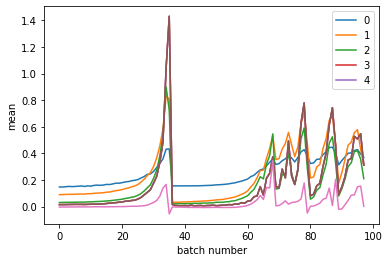

In [68]:
for o in act_means: plt.plot(o)
plt.legend(range(5))
plt.xlabel('batch number')
plt.ylabel('mean');

### Hook class

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4836)

In [69]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    if model.training:
        means.append(outp.data.mean())
        stds .append(outp.data.std())

NB: In fastai we use a `bool` param to choose whether to make it a forward or backward hook. In the above version we're only supporting forward hooks.

In [70]:
# callback functions list
cbfs

[exp.nb_05b.Recorder,
 functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x000001C7EA48D378>),
 __main__.CudaCallback,
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x000001C780032378>)]

In [71]:
len(cbfs)

4

In [72]:
# create model, Learner and Runner objects
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [73]:
# create a list with a hook class corresponding to each layer
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [74]:
# train
run.fit(1, learn)

train: [1.90023921875, tensor(0.3347, device='cuda:0')]
valid: [0.69378623046875, tensor(0.7731, device='cuda:0')]


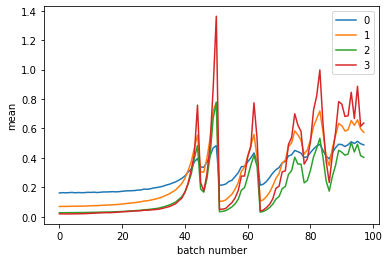

In [75]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4))
plt.xlabel('batch number')
plt.ylabel('mean');

In [76]:
# how many training samples?
len(data.train_ds.x)

50000

In [77]:
# how many training batches?
len(data.train_dl)

98

In [78]:
# how many validation samples?
len(data.valid_ds.x)

10000

In [79]:
# how many validation batches?
len(data.valid_dl)

10

### A Hooks class

Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:
- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices (`[True,False,False,True,...]`)

The `__iter__` method is there to be able to do things like `for x in ...`.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4972)

In [80]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [81]:
dir(ListContainer)

['__class__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__']

In [82]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [83]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [84]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

We can use it to write a `Hooks` class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [85]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [86]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [87]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x000001C780615B00>, <__main__.Hook object at 0x000001C7806150F0>, <__main__.Hook object at 0x000001C780615470>, <__main__.Hook object at 0x000001C780615F60>, <__main__.Hook object at 0x000001C7806151D0>, <__main__.Hook object at 0x000001C780615780>, <__main__.Hook object at 0x000001C7806153C8>]

In [88]:
hooks.remove()

In [89]:
hooks

Hooks (7 items)
[<__main__.Hook object at 0x000001C780615B00>, <__main__.Hook object at 0x000001C7806150F0>, <__main__.Hook object at 0x000001C780615470>, <__main__.Hook object at 0x000001C780615F60>, <__main__.Hook object at 0x000001C7806151D0>, <__main__.Hook object at 0x000001C780615780>, <__main__.Hook object at 0x000001C7806153C8>]

In [90]:
# get a training batch and reshape the image from a vector into an array
x,y = next(iter(data.train_dl))
print(x.shape)
x = mnist_resize(x).cuda()
print(x.shape)

torch.Size([512, 784])
torch.Size([512, 1, 28, 28])


In [91]:
x.mean(),x.std()

(tensor(-0.0066, device='cuda:0'), tensor(0.9938, device='cuda:0'))

In [92]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.1887, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3287, device='cuda:0', grad_fn=<StdBackward0>))

In [93]:
for layer in model:
    if isinstance(layer, nn.Sequential):
        init.kaiming_normal_(layer[0].weight)
        layer[0].bias.data.zero_()

In [94]:
# kaiming normal initialization pushes the std closer to 1
p = model[0](x)
p.mean(),p.std()

(tensor(0.4500, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9381, device='cuda:0', grad_fn=<StdBackward0>))

Having given an `__enter__` and `__exit__` method to our `Hooks` class, we can use it as a context manager. This makes sure that onces we are out of the `with` block, all the hooks have been removed and aren't there to pollute our memory.

train: [2.44728125, tensor(0.1149, device='cuda:0')]
valid: [2.302530859375, tensor(0.1064, device='cuda:0')]
train: [2.30153171875, tensor(0.1133, device='cuda:0')]
valid: [2.30252265625, tensor(0.1064, device='cuda:0')]


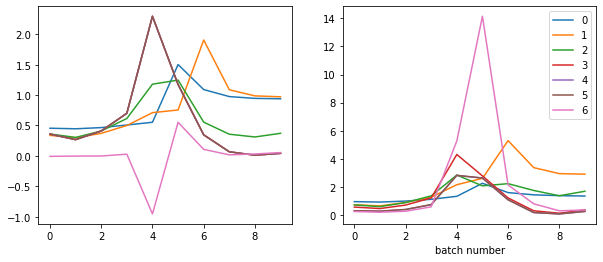

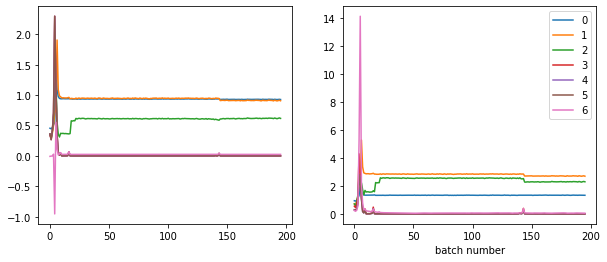

In [95]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        plt.xlabel('batch number')
    plt.legend(range(7));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
        plt.xlabel('batch number')
    plt.legend(range(7));

### Other statistics

Let's store more than the means and stds and plot histograms of our activations now.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5233)

In [96]:
# refactor append_stats() to include histograms
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    if(model.training):
        means.append(outp.data.mean().cpu())
        stds .append(outp.data.std().cpu())
        hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [97]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [98]:
for layer in model:
    if isinstance(layer, nn.Sequential):
        init.kaiming_normal_(layer[0].weight)
        layer[0].bias.data.zero_()

In [99]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

train: [2.0125353125, tensor(0.2949, device='cuda:0')]
valid: [0.99160673828125, tensor(0.6845, device='cuda:0')]


In [100]:
# Thanks to @ste for initial version of histgram plotting code
# stack stds, transpose, convert to float, and take natural log of 1 + value
# this object is not a histogram, but rather a scatter plot of the 98 batches along horizontal axis vs 
# stds along the y axis 
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5582)

torch.Size([40, 98])
torch.Size([40, 98])
torch.Size([40, 98])
torch.Size([40, 98])


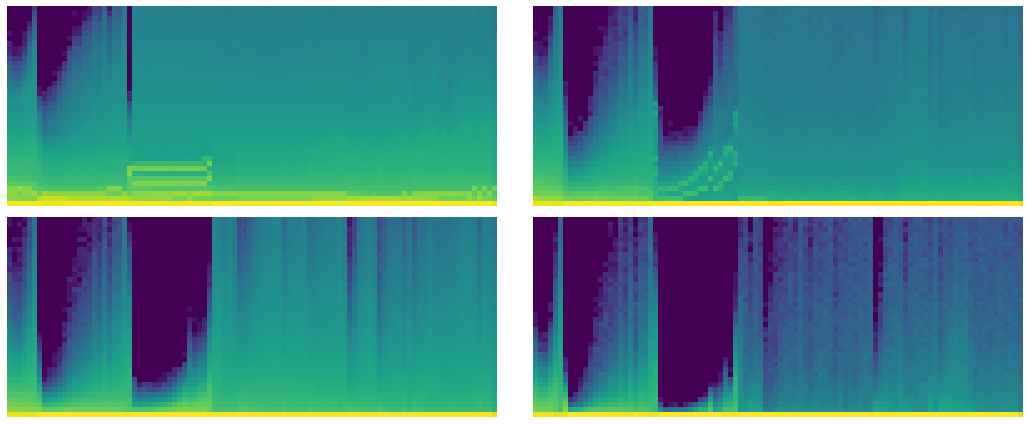

In [101]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    print(torch.stack(h.stats[2]).t().size())
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

From the histograms, we can easily get more informations like the min or max of the activations

In [102]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

## a relatively large fraction of activations are near zero

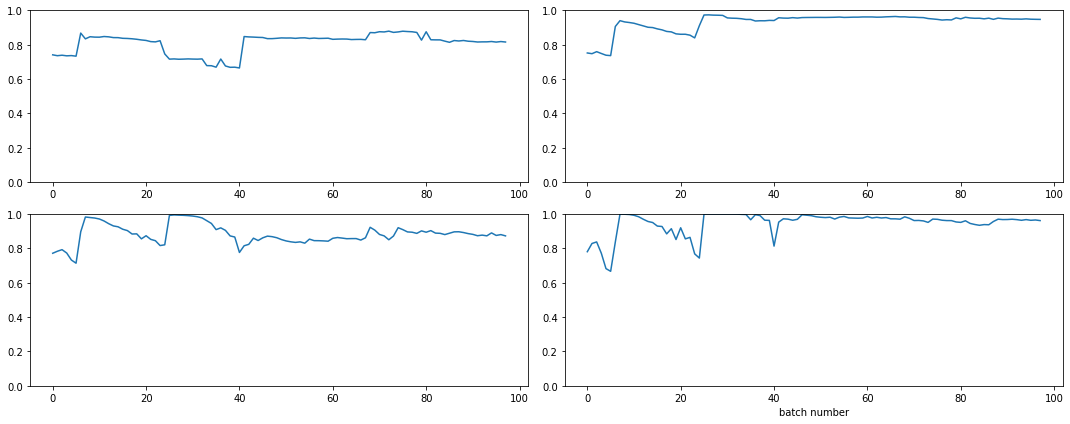

In [103]:
# get the fraction of activation values that are near zero
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
    plt.xlabel('batch number')
plt.tight_layout()

## Generalized ReLU

Now let's use our model with a generalized ReLU that can be shifted and with maximum value.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5390)

In [104]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    # options for leaky ReLU, sub means subtract 0.5, and maxv means apply a maximum cutoff
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            # a is leak parameter
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [105]:
# refactor append_stats to add histograms of the activations
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    if(model.training):
        means.append(outp.data.mean().cpu())
        stds .append(outp.data.std().cpu())
        hists.append(outp.data.cpu().histc(40,-7,7))

In [106]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.460434140625, tensor(0.8571, device='cuda:0')]
valid: [0.17463489990234374, tensor(0.9487, device='cuda:0')]


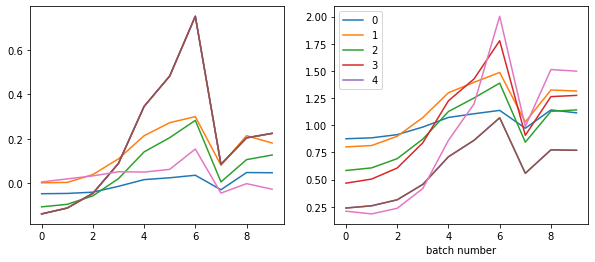

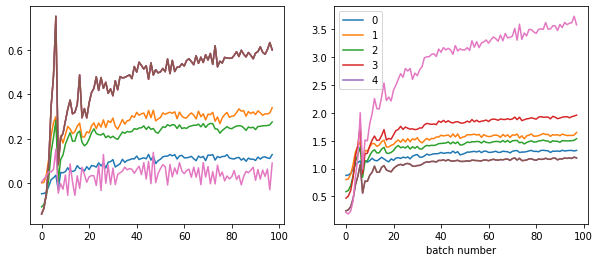

In [107]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        plt.xlabel('batch number')
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
        plt.xlabel('batch number')
    plt.legend(range(5));

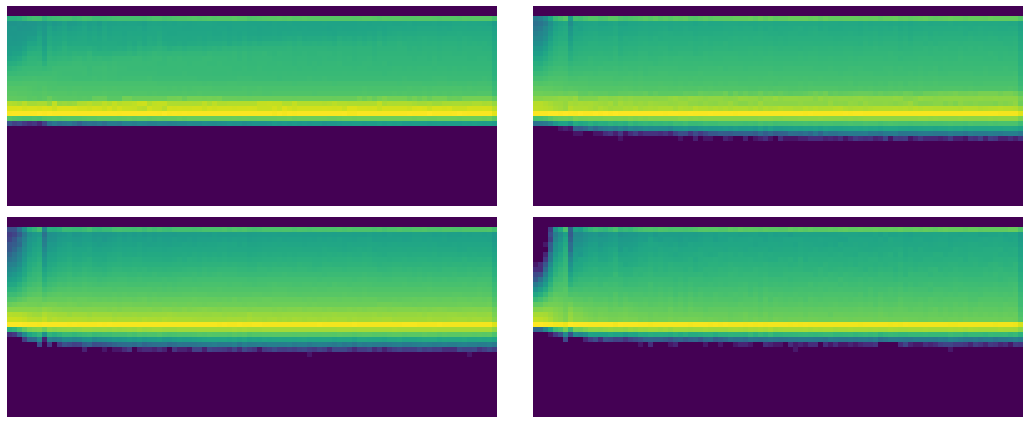

In [108]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [109]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

## now a much smaller fraction of the activations are close to zero

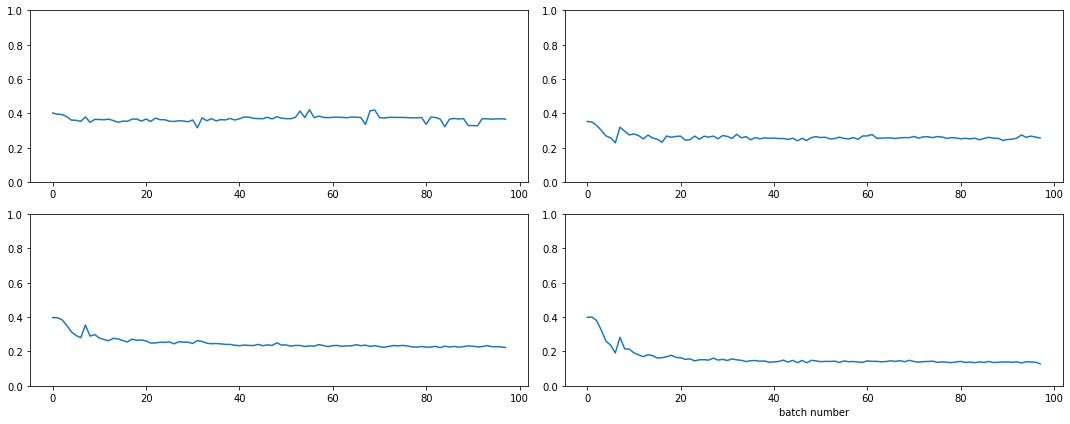

In [110]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
    plt.xlabel('batch number')
plt.tight_layout()

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5705)

In [111]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [112]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [113]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [114]:
run.fit(8, learn)

train: [0.987195859375, tensor(0.6900, device='cuda:0')]
valid: [0.297649755859375, tensor(0.9136, device='cuda:0')]
train: [0.3882545703125, tensor(0.8837, device='cuda:0')]
valid: [0.1848593505859375, tensor(0.9449, device='cuda:0')]
train: [0.16911814453125, tensor(0.9497, device='cuda:0')]
valid: [0.11633424072265625, tensor(0.9652, device='cuda:0')]
train: [0.1117717578125, tensor(0.9662, device='cuda:0')]
valid: [0.147650927734375, tensor(0.9555, device='cuda:0')]
train: [nan, tensor(0.1498, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]


Uniform init may provide more useful initial weights (normal distribution puts a lot of them at 0).

In [115]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [116]:
run.fit(8, learn)

train: [0.972789140625, tensor(0.7013, device='cuda:0')]
valid: [0.352765625, tensor(0.8914, device='cuda:0')]
train: [0.29070595703125, tensor(0.9127, device='cuda:0')]
valid: [0.16045386962890626, tensor(0.9518, device='cuda:0')]
train: [0.234289765625, tensor(0.9306, device='cuda:0')]
valid: [0.1275151123046875, tensor(0.9634, device='cuda:0')]
train: [0.19621650390625, tensor(0.9408, device='cuda:0')]
valid: [0.105385205078125, tensor(0.9707, device='cuda:0')]
train: [0.088387138671875, tensor(0.9727, device='cuda:0')]
valid: [0.080850732421875, tensor(0.9769, device='cuda:0')]
train: [0.061817470703125, tensor(0.9807, device='cuda:0')]
valid: [0.066534375, tensor(0.9811, device='cuda:0')]
train: [0.0461434326171875, tensor(0.9862, device='cuda:0')]
valid: [0.06411973876953125, tensor(0.9829, device='cuda:0')]
train: [0.03822198974609375, tensor(0.9885, device='cuda:0')]
valid: [0.061226470947265625, tensor(0.9838, device='cuda:0')]


## Export

Here's a handy way to export our module without needing to update the file name - after we define this, we can just use `nb_auto_export()` in the future (h/t Stas Bekman):

In [117]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [118]:
nb_auto_export()

<IPython.core.display.Javascript object>